In [2]:
import random

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class Exp3(object):
    
    def __init__(self, gamma, num_arms):
        self.gamma = gamma
        self.num_arms = num_arms
        self.weights = np.ones(num_arms)
        self.prob_distr = np.zeros(num_arms)
        self.arm_t = 0
        for i in xrange(self.prob_distr.shape[0]):
            self.prob_distr[i] = (1-self.gamma)*(self.weights[i]/sum(self.weights)) + self.gamma/self.num_arms
    
    def play_arm(self):
        self.arm_t = np.random.choice(self.num_arms, 1, p=list(self.prob_distr))[0]
        return self.arm_t
    
    def update_distr(self,reward_t): 
        a_t = self.arm_t;
        #print reward_t
        x_t = reward_t/self.prob_distr[a_t]
        #print x_t
        self.weights[a_t] = self.weights[a_t]*np.exp(self.gamma*x_t/self.num_arms)
        #print self.weights
        #self.prob_distr[a_t] = (1-self.gamma)*(self.weights[a_t]/sum(self.weights)) + self.gamma/self.num_arms
        for i in xrange(self.prob_distr.shape[0]):
            self.prob_distr[i] = (1-self.gamma)*(self.weights[i]/sum(self.weights)) + self.gamma/self.num_arms
            

In [5]:
class Policy_regret_min(Exp3):
    
    def __init__(self, gamma, num_arms, memory, tau):
        Exp3.__init__(self, gamma, num_arms)
        self.memory = memory
        self.z_t = np.random.randint(num_arms)
        self.reward_t = 0
        self.tau = tau
        
    def play_arm(self, curr_round):
        if (curr_round-1)%self.tau == 0:
            self.z_t = super(Policy_regret_min, self).play_arm()
        return self.z_t
    
    def update_distr(self,rewards_t):
        self.reward_t = np.sum(rewards_t)/self.memory
        super(Policy_regret_min, self).update_distr(self.reward_t)
        

In [6]:
class Game:
    
    def __init__(self, gamma, utils, memories, T):
        self.utils = utils
        self.memories = memories
        self.taus = np.ones(len(memories))
        self.players = []
        for i in xrange(len(memories)):
            num_arms = utils.shape[i]
            if memories[i] == 1:
                tau = 1
            else:
                tau = max(memories[i],np.ceil(np.power(num_arms*np.log(num_arms),(-1.0/3.0))*np.power(T,1.0/3.0)))
            #self.players.append(Policy_regret_min(np.sqrt((1.0*memories[i])/T)*gamma, utils.shape[i], memories[i], T))
            self.players.append(Policy_regret_min(gamma*(np.sqrt(tau))/np.sqrt(T), utils.shape[i], memories[i], tau))
            self.taus[i] = tau
        self.curr_round = 0
        self.rewards = [np.zeros(memories[i]) for i in xrange(len(memories))]
        
    def play_round(self):
        #self.curr_round+=1
        actions = tuple(self.players[i].play_arm(self.curr_round) for i in xrange(len(memories))) 
        for i in xrange(len(memories)):
            self.rewards[i][self.curr_round%self.memories[i]-1] = self.utils[actions][i]
            if (self.curr_round+1)%self.taus[i] == 0:
                self.players[i].update_distr(self.rewards[i])
        self.curr_round+=1
        return actions


In [10]:
T=20000
memories = [1,10]
#utils = np.array([[(0.5,1.0),(0.0,0.0)],[(0.0,0.0),(0.5,0.5)]])
utils = np.array([[(1,2),(0.0,0.0)],[(0.0,0.0),(2,1)]])
gamma = 1.0

In [11]:
game = Game(gamma, utils, memories,T)

[[ 0.01165189  0.01355843]
 [ 0.0920683   0.88277138]] 

[ 0.02521032  0.97483968]   [ 0.10372019  0.89632981] 

[[ 0.0107  0.013 ]
 [ 0.1043  0.872 ]]


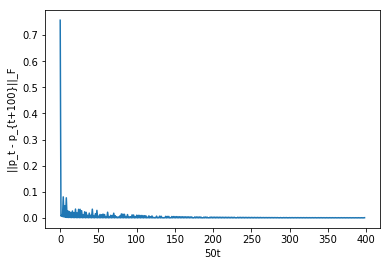

In [12]:
game.play_round();
avr_distr = np.outer(np.array(game.players[0].prob_distr),np.array(game.players[1].prob_distr))
p1_distr = np.array(game.players[0].prob_distr)
p2_distr = np.array(game.players[1].prob_distr)
avr_emp_distr = np.zeros(utils.shape[:-1])
avr_emp_distrs = []
for i in xrange(T):
    actions = game.play_round()
    #avr_distr += (i+1)*np.outer(np.array(game.players[0].prob_distr),np.array(game.players[1].prob_distr))/(i+2)
    avr_distr += np.outer(np.array(game.players[0].prob_distr),np.array(game.players[1].prob_distr))
    p1_distr += np.array(game.players[0].prob_distr)
    p2_distr += np.array(game.players[1].prob_distr)
    avr_emp_distr[actions] += 1
    if i%100 == 0 or (i+1)%100 == 0:
        #print "round ", i
        #print "p1 distr,", game.players[0].prob_distr, ", p1 action,", game.players[0].z_t, ", p1 reward,", game.players[0].reward_t
        #print "p2 distr,", game.players[1].prob_distr, ", p2 action,", game.players[1].z_t, ", p2 reward,", game.players[1].reward_t, "\n"
        avr_emp_distrs.append(avr_emp_distr/(i+1))
print avr_distr/T, "\n"
print p1_distr/T, " ", p2_distr/T, "\n"
print avr_emp_distr/T
a = [x[0]-x[1] for x in zip(avr_emp_distrs[:-1],avr_emp_distrs[1:])]
plt.plot([np.linalg.norm(x) for x in a])
plt.ylabel('||p_t - p_{t+100}||_F')
plt.xlabel('50t')
plt.show()